In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import os
import time as tm
import Sprayer_PDE as SP

import pypolo2

# Environment -- PINNS

In [2]:
Setting = pypolo2.utilities.Config()

env_model = SP.Diffusion_Model(x_range = Setting.grid_x, y_range = Setting.grid_y,\
                 initial_field =  Setting.env, R_field =  Setting.R, data_sprayer_train = Setting.data_sprayer_train, t_start = 0) # build model
Setting.env = env_model.solve(Setting.delta_t)


100%|██████████| 2.0/2.0 [00:01<00:00,  1.50it/s]    


In [3]:
# 确定存放地址
starttime = Setting.starttime.replace(' ', '-').replace(':', '-')
Savedir = './outputs/{}/releaserate_{}'.format(Setting.strategy_name,"%03d" %(Setting.delta_t*100))
Savename = 'seed{}'.format(Setting.seed)
Setting.save_dir = Savedir
Setting.save_name = Savename
evaluator = pypolo2.experiments.Evaluator()
logger = pypolo2.experiments.Logger(None, Setting)

# Sensor

In [4]:
sensor = pypolo2.sensors.Sprinkler(
    Setting = Setting
)

# Pilot Survey

In [5]:
rng = pypolo2.experiments.utilities.seed_everything(Setting = Setting)

Set random seed to 0 in random, numpy, and torch.


# Set initual data

In [6]:
# 初始化污染源
if Setting.randomsource == True:
    # gengerate two set of random numbers for source locations
    numbers = rng.randint(0, 19, size=Setting.sourcenum * 2)
    pairs = rng.choice(numbers, size=(Setting.sourcenum, 2), replace=False)
    for i in range(Setting.sourcenum):
        number = rng.randint(150, 300, size=1)
        Setting.RR[i,0] = int(pairs[i,0])
        Setting.RR[i,1] = int(pairs[i,1])
        Setting.RR[i,2] = number

print(Setting.RR)
#  每周期更新源信息,源是缓慢变化的，源会不断变强到顶峰，然后变弱。定义一个强度系数
s = 1
Setting.R =  -6 * np.ones((Setting.grid_x, Setting.grid_y)) + 13 * np.random.random((Setting.grid_x, Setting.grid_y))
for i in range(Setting.sourcenum):
        Setting.R[Setting.RR[i,0],Setting.RR[i,1]] = s*Setting.RR[i,2]
        
env_model = SP.Diffusion_Model(x_range = Setting.grid_x, y_range = Setting.grid_y,\
                 initial_field =  Setting.env, R_field =  Setting.R, data_sprayer_train = Setting.data_sprayer_train, t_start = 0) # build model

y_init = np.zeros((Setting.num_init_samples,1))
y_stations = np.zeros((Setting.station_size*Setting.time_before_sche,1))
time_init = np.zeros((Setting.num_init_samples,1))
time_stations = np.zeros((Setting.station_size*Setting.time_before_sche,1))

#固定站的观测的观测
for time in range(Setting.time_before_sche):
    # y_stations[Setting.station_size*time:Setting.station_size*(time+1)] = sensor.sense(states=Setting.x_station, rng=rng).reshape(-1, 1)
    # time_stations[Setting.station_size*time:Setting.station_size*(time+1)] = (time-Setting.time_before_sche+1)*Setting.time_co
    time_stations[Setting.station_size*time:Setting.station_size*(time+1)] = (time-Setting.time_before_sche+1)*1
    # time_stations[Setting.station_size*time:Setting.station_size*(time+1)] = (time-10+1)*Setting.time_co
    Setting.env = env_model.solve((time+1)*Setting.delta_t)
    sensor.set_env(Setting.env)
    
#假设每次观测后均变化时间，环境也随之发生变化
for time in range(Setting.num_init_samples):
    y_init[time] = sensor.sense(states=Setting.x_init[time], rng=rng).reshape(-1, 1)
    if time == 0:
        y_stations[:] = y_init[time] - 20
    # time_init[time] = (time+1)*Setting.time_co
    time_init[time] = (time+1)*1
    Setting.env = env_model.solve((1+Setting.time_before_sche+time)*Setting.delta_t)
    sensor.set_env(Setting.env)
    
Setting.x_init = np.hstack((Setting.x_init,time_init))

Setting.x_stations = Setting.x_station
for i in range(Setting.time_before_sche-1):
    Setting.x_stations = np.vstack((Setting.x_stations,Setting.x_station))
Setting.x_stations = np.hstack((Setting.x_stations,time_stations))

Setting.x_init = np.vstack((Setting.x_stations,Setting.x_init))
y_init = np.vstack((y_stations,y_init))

[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:00<00:00,  2.21it/s]    
100%|██████████| 4.0/4.0 [00:00<00:00,  7.08it/s]    
100%|██████████| 6.0/6.0 [00:00<00:00,  7.50it/s]    
100%|██████████| 8.0/8.0 [00:01<00:00,  7.80it/s]    
100%|██████████| 10.0/10.0 [00:01<00:00,  7.86it/s]   
100%|██████████| 12.0/12.0 [00:01<00:00,  7.94it/s]   


# Model

In [7]:
Setting.time_stamp = Setting.x_init[:,2].max(axis=0, keepdims=False)

In [8]:
kernel = pypolo2.kernels.RBF(Setting)

In [9]:
model = pypolo2.models.GPR(
    x_train=Setting.x_init,
    y_train=y_init,
    kernel=kernel,
    noise=Setting.init_noise,
    lr_hyper=Setting.lr_hyper,
    lr_nn=Setting.lr_nn,
    is_normalized = True,
    time_stamp = Setting.time_stamp,
)

In [10]:
model.optimize(num_iter=model.num_train, verbose=True)

Iter: 05 loss:  8.64: 100%|██████████| 6/6 [00:00<00:00, 113.51it/s]


# Robot

In [11]:
vehicle_team = dict()
for i in range(Setting.team_size):
    robot = pypolo2.robots.SPRINKLER_REPLENISHANYWHERE(
        init_state = np.array([Setting.x_init[-1, 0], Setting.x_init[-1, 1]]),
        Setting = Setting
    )
    vehicle_team[i+1] = robot #因此team的id从1开始

# Strategy

In [12]:
strategy = pypolo2.strategies.SALatticePlanningMISprinklerControl_mimethod2(
            task_extent=Setting.task_extent,
            rng=rng,
            vehicle_team=vehicle_team,
        )
Setting.strategy = strategy

# Experiment

In [13]:
#定义需要随时间更新的训练过程
def run(rng, model, Setting, sensor, evaluator, logger, vehicle_team) -> None:
    current_step = 0 #总规划长度
    adaptive_step = Setting.adaptive_step #自适应长度
    # change_step = Setting.R_change_interval - 0*Setting.adaptive_step # 污染源变化间隔
    change_step = 0
    spray_effect = 0 # 洒水效果
    result, MI_information, observed_env, computed_effect = None, None, None, None
    while current_step < Setting.max_num_samples:
        # 计算用于显示的信息量，目标估计，洒水效果
        allpoint_list = []
        for i in range (Setting.task_extent[0],Setting.task_extent[1]):
            for j in range (Setting.task_extent[2],Setting.task_extent[3]):
                allpoint_list.append([i, j, model.time_stamp])
        allpoint = np.array(allpoint_list)
        mean, _ = model(allpoint)
        sprayeffect_all = pypolo2.objectives.sprayeffect.spray_effect(allpoint, allpoint, mean, Setting.task_extent).ravel()
        prior_diag_std, poste_diag_std, _, _ = model.prior_poste(allpoint)
        hprior = pypolo2.objectives.entropy.gaussian_entropy(prior_diag_std.ravel())
        hposterior = pypolo2.objectives.entropy.gaussian_entropy(poste_diag_std.ravel())
        mi_all = hprior - hposterior
        if np.any(mi_all < 0.0):
            print(mi_all.ravel())
            raise ValueError("Predictive MI < 0.0!")
        MI_information = np.zeros((Setting.task_extent[1]-Setting.task_extent[0],Setting.task_extent[3]-Setting.task_extent[2]))
        observed_env = np.zeros((Setting.task_extent[1]-Setting.task_extent[0],Setting.task_extent[3]-Setting.task_extent[2]))
        computed_effect = np.zeros((Setting.task_extent[1]-Setting.task_extent[0],Setting.task_extent[3]-Setting.task_extent[2]))
        for i in range (Setting.task_extent[0],Setting.task_extent[1]):
            for j in range (Setting.task_extent[2],Setting.task_extent[3]):
                MI_information[i,j] = mi_all[i*(Setting.task_extent[3]-Setting.task_extent[2])+j]
                observed_env[i,j] = mean[i*(Setting.task_extent[3]-Setting.task_extent[2])+j,0]
                computed_effect[i,j] = sprayeffect_all[i*(Setting.task_extent[3]-Setting.task_extent[2])+j]
                
        Setting.current_step = current_step
        # scheduling and update agent goals 计算搜索时间
        if adaptive_step >= Setting.adaptive_step:
            start = tm.time()
            result = strategy.get(model = model, Setting = Setting, pred = observed_env)
            adaptive_step = 0
            for id, vehicle in vehicle_team.items():
                vehicle.set_goals(result[id][0],result[id][1])
            end = tm.time()
            print('search_time')
            print(end-start)    
            
        # calculate metrix and save 
        coverage, mean_airpollution, max_airpollution = evaluator.eval_results(Setting.env, Setting.task_extent, vehicle_team)
        logger.append(current_step, Setting.env, observed_env, MI_information, computed_effect, vehicle_team, coverage, mean_airpollution, max_airpollution, spray_effect)
           
        # change source,每经过R_change_interval后，改变源分布和强度，
        if change_step >= Setting.R_change_interval:
            change_step = 0
            if Setting.randomsource == True:
                # gengerate two set of random numbers for source locations
                numbers = rng.randint(0, 19, size=Setting.sourcenum * 2)
                pairs = rng.choice(numbers, size=(Setting.sourcenum, 2), replace=False)
                for i in range(Setting.sourcenum):
                    number = rng.randint(150, 300, size=1)
                    Setting.RR[i,0] = int(pairs[i,0])
                    Setting.RR[i,1] = int(pairs[i,1])
                    Setting.RR[i,2] = number

        print(Setting.RR)
        #  每周期更新源信息,源是缓慢变化的，源会不断变强到顶峰，然后变弱。定义一个强度系数
        s = 1
        # if change_step == 0:
        #     s = 0.2
        if change_step == 0 or change_step == Setting.R_change_interval - 1:
            s = 0.5
        Setting.R =  -6 * np.ones((Setting.grid_x, Setting.grid_y)) + 13 * np.random.random((Setting.grid_x, Setting.grid_y))
        for i in range(Setting.sourcenum):
             Setting.R[Setting.RR[i,0],Setting.RR[i,1]] = s*Setting.RR[i,2]
             
        # 计算如果没有更新洒水时的环境变化
        env_model1 = SP.Diffusion_Model(x_range = Setting.grid_x, y_range = Setting.grid_y,\
                 initial_field =  Setting.env, R_field =  Setting.R, data_sprayer_train = Setting.data_sprayer_train, t_start = Setting.current_step * Setting.delta_t) # build model
        env_withoutspray = env_model1.solve(Setting.delta_t)
        # update state 并将车辆的轨迹和洒水轨迹取出来
        x_new = []
        y_new = []
        for id, vehicle in vehicle_team.items():
            vehicle.update()
            current_state = vehicle.state.copy().reshape(1, -1)
            x_new.append(current_state)
            y_new.append(sensor.sense(current_state, rng).reshape(-1, 1))
            if Setting.current_step == 0:
                Setting.data_sprayer_train.append(pd.DataFrame())
            else:
                if vehicle.spray_flag == True:
                    new_pd = pd.DataFrame({"time":(Setting.current_step + 1) * Setting.delta_t, "x":current_state[0,0],\
                                            "y":current_state[0,1], "spray_volume":500},index=[0])
                    # Setting.data_sprayer_train[id-1] = Setting.data_sprayer_train[id-1].append(new_pd, ignore_index=True)
                    Setting.data_sprayer_train[id-1] = pd.concat([Setting.data_sprayer_train[id-1],new_pd])
        # 计算带入洒水后的环境情况
        env_model2 = SP.Diffusion_Model(x_range = Setting.grid_x, y_range = Setting.grid_y,\
                 initial_field =  Setting.env, R_field =  Setting.R, data_sprayer_train = Setting.data_sprayer_train, t_start = Setting.current_step * Setting.delta_t) # build model
        Setting.env = env_model2.solve(Setting.delta_t)
        sensor.set_env(Setting.env)
        # 计算洒水效果
        spray_effect = np.sum(env_withoutspray - Setting.env)
            
        # using new data to update gpr model
        x_new = np.concatenate(x_new, axis=0)
        y_new = np.concatenate(y_new, axis=0)
        #add time dim
        model.time_stamp = model.time_stamp + Setting.time_co
        Setting.time_stamp = model.time_stamp
        model_input = np.zeros((x_new.shape[0],3))
        model_input[:,0:2] = x_new
        model_input[:,2:3] = model.time_stamp
        #optimize model
        model.add_data(model_input, y_new)
        model.optimize(num_iter=len(y_new), verbose=False)
        
        adaptive_step = adaptive_step + 1    
        current_step = current_step + 1
        change_step = change_step + 1  
    return 0

In [14]:
start = tm.time()
Setting.strategy = strategy
run(rng, model, Setting, sensor, evaluator, logger, vehicle_team)
# pypolo2.experiments.utilities.print_metrics(logger, Setting.max_num_samples-1)
end = tm.time()
# logger.save(end-start)  # I temporarily removed "makefile()".

current_turn
1.0
sche_step
18
mi_high
8.045053165393705
sprayeffectarv
[0.04706408 0.05649773 0.05090442 0.04854466 0.04878176]
CurrentInfo
0.8110791820349732
object_mi
[12.06757975 12.06757975 12.06757975 12.06757975 12.06757975]
enough_info
[False False False False False]
single_playout
176.0
search_time
232.0321910381317
[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:00<00:00,  2.01it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  2.05it/s]    


[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:01<00:00,  1.69it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  2.23it/s]    


current_turn
2.0
sche_step
18
mi_high
14.509256404727896
sprayeffectarv
[0.09446419 0.06924623 0.04689953 0.07431903 0.08213929]
CurrentInfo
4.170575354772227
object_mi
[21.76388461 21.76388461 21.76388461 21.76388461 21.76388461]
enough_info
[False False False False False]
single_playout
115.0
search_time
180.71200680732727
[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:01<00:00,  1.95it/s]    
100%|██████████| 2.0/2.0 [00:01<00:00,  1.94it/s]    


[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:01<00:00,  1.93it/s]    
100%|██████████| 2.0/2.0 [00:01<00:00,  1.53it/s]    


current_turn
3.0
sche_step
18
mi_high
19.26671251961049
sprayeffectarv
[0.95689748 0.07629325 0.03978201 0.0818683  1.09191207]
CurrentInfo
9.14178619057132
object_mi
[28.90006878 28.90006878 28.90006878 28.90006878 28.90006878]
enough_info
[False False False False False]
single_playout
96.0
search_time
154.7144901752472
[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:01<00:00,  1.93it/s]    
100%|██████████| 2.0/2.0 [00:01<00:00,  1.84it/s]    


[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:01<00:00,  1.93it/s]    
100%|██████████| 2.0/2.0 [00:01<00:00,  1.91it/s]    


current_turn
4.0
sche_step
18
mi_high
24.240634117798095
sprayeffectarv
[6.48681176 0.08490409 0.05457727 2.14733963 6.21424808]
CurrentInfo
15.62908936548155
object_mi
[36.36095118 36.36095118 36.36095118 36.36095118 36.36095118]
enough_info
[False False False False False]
single_playout
87.0
search_time
141.83765625953674
[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:00<00:00,  2.17it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  2.02it/s]    


[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:01<00:00,  1.96it/s]    
100%|██████████| 2.0/2.0 [00:01<00:00,  1.98it/s]    


current_turn
5.0
sche_step
18
mi_high
33.26550211473215
sprayeffectarv
[32.4167376   0.07908783  0.07778782  0.10505512 10.89030459]
CurrentInfo
23.11186788631083
object_mi
[33.26550211 49.89825317 49.89825317 49.89825317 33.26550211]
enough_info
[ True False False False  True]
single_playout
81.0
search_time
139.95062494277954
[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:01<00:00,  1.86it/s]    
100%|██████████| 2.0/2.0 [00:01<00:00,  1.89it/s]    


[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:01<00:00,  1.86it/s]    
100%|██████████| 2.0/2.0 [00:01<00:00,  1.88it/s]    


current_turn
6.0
sche_step
18
mi_high
40.73143450527788
sprayeffectarv
[83.49188102  0.07113032  0.07912584  0.09081907 20.82883912]
CurrentInfo
31.16354338856874
object_mi
[36.65829105 61.09715176 61.09715176 61.09715176 38.69486278]
enough_info
[ True False False False  True]
single_playout
78.0
search_time
134.12437891960144
[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:01<00:00,  1.42it/s]    
100%|██████████| 2.0/2.0 [00:01<00:00,  1.88it/s]    


[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:01<00:00,  1.82it/s]    
100%|██████████| 2.0/2.0 [00:01<00:00,  1.80it/s]    


current_turn
7.0
sche_step
18
mi_high
49.452225509384455
sprayeffectarv
[95.43826789  0.08509984  0.08318332  0.12070881 23.00895394]
CurrentInfo
38.157327019112344
object_mi
[44.50700296 74.17833826 74.17833826 74.17833826 46.97961423]
enough_info
[ True False False False  True]
single_playout
75.0
search_time
123.11294937133789
[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:01<00:00,  1.82it/s]    
100%|██████████| 2.0/2.0 [00:01<00:00,  1.44it/s]    


[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:01<00:00,  1.96it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  2.17it/s]    


current_turn
8.0
sche_step
18
mi_high
56.400623230744735
sprayeffectarv
[96.34049319  0.08605538  0.07675918  0.63916229 27.33532662]
CurrentInfo
45.62238290462681
object_mi
[50.76056091 54.70860453 54.70860453 54.70860453 53.58059207]
enough_info
[ True  True  True  True  True]
single_playout
73.0
search_time
128.16731643676758
[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:01<00:00,  1.73it/s]    
100%|██████████| 2.0/2.0 [00:01<00:00,  1.79it/s]    


[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:01<00:00,  1.76it/s]    
100%|██████████| 2.0/2.0 [00:01<00:00,  1.39it/s]    


current_turn
9.0
sche_step
18
mi_high
60.667078323898494
sprayeffectarv
[79.02397274  0.08755946  0.0929942   4.14335243 30.68277133]
CurrentInfo
54.05457972261985
object_mi
[60.66707832 58.84706597 58.84706597 58.84706597 60.66707832]
enough_info
[ True  True  True  True  True]
single_playout
72.0
search_time
144.86509728431702
[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:01<00:00,  1.82it/s]    
100%|██████████| 2.0/2.0 [00:01<00:00,  1.71it/s]    


[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:01<00:00,  1.74it/s]    
100%|██████████| 2.0/2.0 [00:01<00:00,  1.67it/s]    


current_turn
10.0
sche_step
18
mi_high
66.56127068805884
sprayeffectarv
[98.39707312  0.09660423  0.1018455  36.94796055 25.13946609]
CurrentInfo
61.73720186542785
object_mi
[59.90514362 61.90198174 61.90198174 63.23320715 63.23320715]
enough_info
[ True  True  True  True  True]
single_playout
71.0
search_time
143.22153544425964
[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:01<00:00,  1.65it/s]    
100%|██████████| 2.0/2.0 [00:01<00:00,  1.67it/s]    


[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:01<00:00,  1.85it/s]    
100%|██████████| 2.0/2.0 [00:01<00:00,  1.83it/s]    


current_turn
11.0
sche_step
18
mi_high
75.22992224037131
sprayeffectarv
[144.35960926   0.09311392   0.10864535  17.74125936  42.02139909]
CurrentInfo
68.22626144806524
object_mi
[67.70693002 69.96382768 69.96382768 71.46842613 71.46842613]
enough_info
[ True  True  True  True  True]
single_playout
70.0
search_time
141.32582235336304
[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:01<00:00,  1.65it/s]    
100%|██████████| 2.0/2.0 [00:01<00:00,  1.56it/s]    


[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:01<00:00,  1.55it/s]    
100%|██████████| 2.0/2.0 [00:01<00:00,  1.60it/s]    


current_turn
12.0
sche_step
18
mi_high
81.69804819443455
sprayeffectarv
[176.04330269   0.10787425   0.11344999  73.10484271  86.51095083]
CurrentInfo
74.40950423060366
object_mi
[73.52824337 75.97918482 75.97918482 73.52824337 73.52824337]
enough_info
[ True  True  True  True  True]
single_playout
69.0
search_time
137.42214274406433
[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:01<00:00,  1.72it/s]    
100%|██████████| 2.0/2.0 [00:01<00:00,  1.64it/s]    


[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:01<00:00,  1.74it/s]    
100%|██████████| 2.0/2.0 [00:01<00:00,  1.65it/s]    


current_turn
13.0
sche_step
18
mi_high
86.0510813054051
sprayeffectarv
[152.11976892   0.09958084   2.80275641  44.22626113  86.7897635 ]
CurrentInfo
79.95491157378838
object_mi
[77.44597317 80.02750561 80.02750561 77.44597317 77.44597317]
enough_info
[ True  True  True  True  True]
single_playout
68.0
search_time
138.74820232391357
[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:01<00:00,  1.32it/s]    
100%|██████████| 2.0/2.0 [00:01<00:00,  1.77it/s]    


[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:01<00:00,  1.80it/s]    
100%|██████████| 2.0/2.0 [00:01<00:00,  1.63it/s]    


current_turn
14.0
sche_step
18
mi_high
90.5498571364681
sprayeffectarv
[119.66995008   0.10267462  16.34118569 102.86380595  77.24494063]
CurrentInfo
85.03441363906026
object_mi
[81.49487142 80.58937285 81.49487142 81.49487142 81.49487142]
enough_info
[ True  True  True  True  True]
single_playout
68.0
search_time
142.13908672332764
[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:01<00:00,  1.60it/s]    
100%|██████████| 2.0/2.0 [00:01<00:00,  1.24it/s]    


[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:01<00:00,  1.65it/s]    
100%|██████████| 2.0/2.0 [00:01<00:00,  1.63it/s]    


current_turn
15.0
sche_step
18
mi_high
97.2472073118972
sprayeffectarv
[135.18027023   0.1164919    8.54270657  74.72404293  89.93266595]
CurrentInfo
90.26456964169783
object_mi
[87.52248658 90.4399028  90.4399028  87.52248658 87.52248658]
enough_info
[ True  True  True  True  True]
single_playout
67.0
search_time
143.02210879325867
[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:01<00:00,  1.55it/s]    
100%|██████████| 2.0/2.0 [00:01<00:00,  1.49it/s]    


[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:01<00:00,  1.26it/s]    
100%|██████████| 2.0/2.0 [00:01<00:00,  1.61it/s]    


current_turn
16.0
sche_step
18
mi_high
99.19478778622455
sprayeffectarv
[169.10976045   4.42565664  11.38136176  61.90632733 153.22278313]
CurrentInfo
96.10953568840878
object_mi
[89.27530901 88.28336113 89.27530901 89.27530901 89.27530901]
enough_info
[ True  True  True  True  True]
single_playout
67.0
search_time
141.59553289413452
[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:01<00:00,  1.84it/s]    
100%|██████████| 2.0/2.0 [00:01<00:00,  1.72it/s]    


[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:01<00:00,  1.75it/s]    
100%|██████████| 2.0/2.0 [00:01<00:00,  1.26it/s]    


current_turn
17.0
sche_step
18
mi_high
102.77070399234887
sprayeffectarv
[190.16976772  23.95776541  29.46516687 143.12573057 168.3091665 ]
CurrentInfo
101.39763976918245
object_mi
[77.07802799 87.35509839 87.35509839 88.38280543 88.38280543]
enough_info
[ True  True  True  True  True]
single_playout
66.0
search_time
152.29494619369507
[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:01<00:00,  1.73it/s]    
100%|██████████| 2.0/2.0 [00:01<00:00,  1.66it/s]    


[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:01<00:00,  1.65it/s]    
100%|██████████| 2.0/2.0 [00:01<00:00,  1.64it/s]    


current_turn
18.0
sche_step
16
mi_high
108.61388832760058
sprayeffectarv
[119.65622095  48.8568714  111.44055511 174.72873717 189.11999507]
CurrentInfo
106.33947425766998
object_mi
[93.40794396 86.89111066 93.40794396 93.40794396 81.46041625]
enough_info
[ True  True  True  True  True]
single_playout
66.0
search_time
145.56776309013367
[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:01<00:00,  1.72it/s]    
100%|██████████| 2.0/2.0 [00:01<00:00,  1.66it/s]    


[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:01<00:00,  1.67it/s]    
100%|██████████| 2.0/2.0 [00:01<00:00,  1.71it/s]    


current_turn
19.0
sche_step
14
mi_high
114.4829297436071
sprayeffectarv
[122.3272928  130.32933641 146.86036461 237.54535669 200.77637876]
CurrentInfo
110.93449154246194
object_mi
[93.87600239 93.87600239 93.87600239 85.86219731 85.86219731]
enough_info
[ True  True  True  True  True]
single_playout
66.0
search_time
128.2408447265625
[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:01<00:00,  1.83it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  2.01it/s]    


[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:00<00:00,  2.09it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  2.17it/s]    


current_turn
20.0
sche_step
12
mi_high
117.3434206575656
sprayeffectarv
[172.3820219  207.02725022 173.34824837 226.77180836 242.97028311]
CurrentInfo
115.678059061628
object_mi
[91.52786811 88.00756549 91.52786811 88.00756549 88.00756549]
enough_info
[ True  True  True  True  True]
single_playout
66.0
search_time
112.76697373390198
[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:01<00:00,  1.70it/s]    
100%|██████████| 2.0/2.0 [00:01<00:00,  1.59it/s]    


[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:01<00:00,  1.69it/s]    
100%|██████████| 2.0/2.0 [00:01<00:00,  1.80it/s]    


current_turn
21.0
sche_step
10
mi_high
118.3011047025067
sprayeffectarv
[167.89078434 169.47890346 194.50856999 262.302502   228.62617329]
CurrentInfo
119.79784172673735
object_mi
[92.27486167 92.27486167 88.72582853 88.72582853 88.72582853]
enough_info
[ True  True  True  True  True]
single_playout
65.0
search_time
79.89759731292725
[[ 16  10 188]
 [  3  10 286]
 [ 17  16 163]]


100%|██████████| 2.0/2.0 [00:01<00:00,  1.38it/s]    
100%|██████████| 2.0/2.0 [00:01<00:00,  1.69it/s]    


[[ 16  10 188]
 [  3  10 286]
 [ 17  16 163]]


100%|██████████| 2.0/2.0 [00:01<00:00,  1.63it/s]    
100%|██████████| 2.0/2.0 [00:01<00:00,  1.58it/s]    


current_turn
22.0
sche_step
8
mi_high
119.53009363018681
sprayeffectarv
[208.17836234 172.74744597 166.72348715 183.42690542 193.26999134]
CurrentInfo
122.8629426855561
object_mi
[89.64757022 93.23347303 93.23347303 89.64757022 89.64757022]
enough_info
[ True  True  True  True  True]
single_playout
65.0
search_time
53.75817847251892
[[ 16  10 188]
 [  3  10 286]
 [ 17  16 163]]


100%|██████████| 2.0/2.0 [00:00<00:00,  2.03it/s]    
100%|██████████| 2.0/2.0 [00:01<00:00,  1.74it/s]    


[[ 16  10 188]
 [  3  10 286]
 [ 17  16 163]]


100%|██████████| 2.0/2.0 [00:00<00:00,  2.59it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  2.68it/s]    


current_turn
23.0
sche_step
8
mi_high
122.57385905640524
sprayeffectarv
[161.30360714 185.88255577 148.40557939 164.54168241 168.37128786]
CurrentInfo
123.62005142119494
object_mi
[105.41351879  91.93039429 105.41351879 105.41351879 105.41351879]
enough_info
[ True  True  True  True  True]
single_playout
65.0
search_time
98.08576583862305
[[ 16  10 188]
 [  3  10 286]
 [ 17  16 163]]


100%|██████████| 2.0/2.0 [00:00<00:00,  2.46it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  2.91it/s]    


[[ 16  10 188]
 [  3  10 286]
 [ 17  16 163]]


100%|██████████| 2.0/2.0 [00:00<00:00,  2.25it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  3.07it/s]    


current_turn
24.0
sche_step
8
mi_high
121.77158249518801
sprayeffectarv
[146.80634463 205.87827034 196.01433151 172.23588995 123.33493205]
CurrentInfo
122.98638694345898
object_mi
[99.85269765 91.32868687 91.32868687 99.85269765 99.85269765]
enough_info
[ True  True  True  True  True]
single_playout
65.0
search_time
85.59516072273254
[[ 16  10 188]
 [  3  10 286]
 [ 17  16 163]]


100%|██████████| 2.0/2.0 [00:00<00:00,  2.98it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  3.10it/s]    


[[ 16  10 188]
 [  3  10 286]
 [ 17  16 163]]


100%|██████████| 2.0/2.0 [00:00<00:00,  2.95it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  2.43it/s]    


current_turn
25.0
sche_step
8
mi_high
123.97328914697883
sprayeffectarv
[114.10023901 137.74211226 199.79653846 183.94788293 138.4585494 ]
CurrentInfo
121.38395214940829
object_mi
[101.6580971  101.6580971   92.97996686  92.97996686 101.6580971 ]
enough_info
[ True  True  True  True  True]
single_playout
65.0
search_time
74.09554886817932
[[ 16  10 188]
 [  3  10 286]
 [ 17  16 163]]


100%|██████████| 2.0/2.0 [00:00<00:00,  2.88it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  3.28it/s]    


[[ 16  10 188]
 [  3  10 286]
 [ 17  16 163]]


100%|██████████| 2.0/2.0 [00:00<00:00,  3.06it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  3.19it/s]    


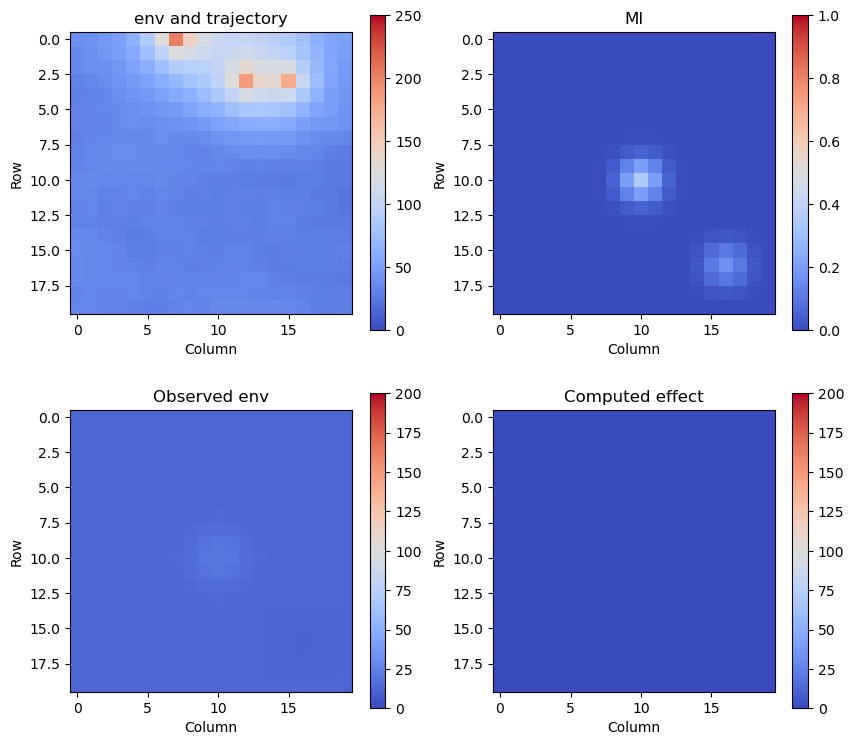

In [15]:
from pypolo2.experiments import visualizer
ani = visualizer.visual(logger)

# Display the animation
from IPython.display import HTML
HTML(ani.to_jshtml())

In [16]:
import math
import numpy as np
Temp = 1
k = math.pow(0.00002, 1 / 10)
k = math.pow(k, 3)
delta_e_2 = -0.1
accept_prob = np.exp(delta_e_2 / (k * Temp))
print(k)
print(accept_prob)

0.03893220474761734
0.07664525292497093


In [17]:
numbers = rng.randint(0, 19, size=10)
pairs = rng.choice(numbers, size=(5, 2), replace=False)
print(pairs)

[[14  7]
 [ 0 11]
 [ 6  8]
 [ 9 10]
 [ 5  8]]


In [18]:
Setting.RR

array([[ 16,  10, 188],
       [  3,  10, 286],
       [ 17,  16, 163]])